In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dill
import os

from typing import List, Tuple, Any, Dict

import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import MiniBatchKMeans

from scipy import stats
from math import sin, cos, sqrt, atan2, radians

%matplotlib inline

### i. Create dataset
---

In [2]:
seed = 33
row_limit = 2000000 
data_dir = '../data/'

rides_use_columns = [
    'Duration', 'Start date', 'End date', 'Start station number', 'End station number', 'Member type'
]
dataset = pd.DataFrame()
for file in os.listdir(os.path.join(data_dir, 'rides')):
    if file.startswith('sample_set'):
        print(f'Reading in {file}...')
        tmp = pd.read_csv(
            os.path.join(data_dir, 'rides', file), 
            nrows=row_limit, 
            usecols=rides_use_columns
        )
        dataset = pd.concat([dataset, tmp], sort=False, ignore_index=True)

stations_use_columns = [
    'TERMINAL_NUMBER', 'LONGITUDE', 'LATITUDE', 'NUMBER_OF_EMPTY_DOCKS', 'NUMBER_OF_BIKES'
]
stations = pd.read_csv(
    os.path.join(data_dir, 'stations/capbs_stations.csv'),
    usecols=stations_use_columns
)

print(f'Modifying target variable "Duration" => "duration_log1p"...')
dataset['duration_log1p'] = np.log1p(dataset.Duration)

hours = 1.5
mins = 2.5
print(f'Removing unreasonably long rides (greater than {hours} hours) ...')
dataset = dataset.loc[(dataset['Duration'] <= (60 * 60 * hours)) & (dataset['Duration'] >= (60 * mins)), :]

print(f'Removing "Unknown" Member type rows...')
dataset = dataset.loc[(dataset['Member type'] != 'Unknown'), :]

dataset = dataset.loc[~(dataset['Start station number'] == 31008) &
                       ~(dataset['Start station number'] == 32051) &
                       ~(dataset['Start station number'] == 32034), :]

dataset = dataset.loc[~(dataset['End station number'] == 31008) &
                       ~(dataset['End station number'] == 32051) &
                       ~(dataset['End station number'] == 32034), :]

print(f'Cleaned Rides Dataset (rows, columns): {dataset.shape}')

Reading in sample_set.csv...
Modifying target variable "Duration" => "duration_log1p"...
Removing unreasonably long rides (greater than 1.5 hours) ...
Removing "Unknown" Member type rows...
Cleaned Rides Dataset (rows, columns): (666134, 7)


In [3]:
print(f'Stations information (rows, columns): {stations.shape}')
stations.loc[:,'station_total_bikes'] = stations.loc[:,'NUMBER_OF_BIKES'] + stations.loc[:,'NUMBER_OF_EMPTY_DOCKS']
stations_start = stations.loc[:, ['station_total_bikes', 'LATITUDE', 'LONGITUDE', 'TERMINAL_NUMBER']]
stations_start.columns = ['station_total_bikes', 'start_station_lat', 'start_station_long', 'Start station number']

stations_end = stations.loc[:, ['LATITUDE', 'LONGITUDE', 'TERMINAL_NUMBER']]
stations_end.columns = ['end_station_lat', 'end_station_long', 'End station number']

dataset = dataset.merge(stations_start, on='Start station number', how='left', sort=False)
dataset = dataset.merge(stations_end, on='End station number', how='left', sort=False)
print(f'Merged Stations information into Rides dataset.')

Stations information (rows, columns): (571, 5)
Merged Stations information into Rides dataset.


In [4]:
testset = dataset.sample(frac=0.33, random_state=seed)
dataset.drop(testset.index, inplace=True)
print(f'Trainset (rows, columns): {dataset.shape}')
print(f'Testset (rows, columns): {testset.shape}')
dataset.head()

Trainset (rows, columns): (446310, 12)
Testset (rows, columns): (219824, 12)


,Duration,Start date,End date,Start station number,End station number,Member type,duration_log1p,station_total_bikes,start_station_lat,start_station_long,end_station_lat,end_station_long
0,1012,2010-09-20 11:27:04,2010-09-20 11:43:56,31208,31108,Member,6.920672,16,38.876300,-77.003700,38.876700,-77.017800
2,1413,2010-09-20 12:10:43,2010-09-20 12:34:17,31100,31201,Member,7.254178,15,38.900300,-77.042900,38.909850,-77.034438
3,1659,2010-09-20 12:16:36,2010-09-20 12:44:15,31111,31208,Member,7.414573,14,38.917200,-77.025900,38.876300,-77.003700
7,2988,2010-09-20 12:41:37,2010-09-20 13:31:25,31206,31603,Member,8.002694,11,38.895200,-77.043600,38.905700,-77.005600
10,277,2010-09-20 13:30:21,2010-09-20 13:34:58,31106,31104,Member,5.627621,23,38.923203,-77.047637,38.922925,-77.042581


### ii Prep features
---

In [5]:
# station_metrics = {}

# def get_distance(c1_lat_long: Tuple[float, float], c2_lat_long: Tuple[float, float]) -> float:
#     return np.sqrt((c1_lat_long[0] - c2_lat_long[0])**2 + (c1_lat_long[1] - c2_lat_long[1])**2)

# def get_station_city_location(station_num: int):
#     return

# def get_average_station_distance(station_num: int):
    
#     return

# def get_median_station_duration(station_num: int):
#     return

# for row in stations_start.iterrows():

In [6]:
# coords = np.vstack((
#     dataset.loc[:,['start_station_long', 'start_station_lat']].values,
#     dataset.loc[:,['end_station_long', 'end_station_lat']].values
# ))

# dataset['week_of_year'] = dataset['Start date'].apply(lambda x: x.weekofyear)
# dataset['day_of_week'] = dataset['Start date'].apply(lambda x: x.dayofweek)
# dataset['hour'] = dataset['Start date'].apply(lambda x: x.hour)

# ride_scaler = StandardScaler()
# ride_scaler.fit(dataset.loc[:,['start_station_long', 'start_station_lat', 'hour', 'day_of_week', 'week_of_year']])

# ride_scaler.fit(dataset.loc[:,['start_station_long', 'start_station_lat', 'hour', 'day_of_week', 'week_of_year']])


# kmeans = MiniBatchKMeans(n_clusters=50, batch_size=100000).fit(rides_features)

In [7]:
# dataset.loc[:, 'ride_cluster'] = kmeans.predict(dataset[['start_station_long', 'start_station_lat']]).astype('str')
# testset.loc[:, 'ride_cluster'] = kmeans.predict(testset[['start_station_long', 'start_station_lat']]).astype('str')

### iii. Pipeline
---

In [8]:
class PrepareRiders(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self._final_columns = None
    
    def _make_time_cyclical(self, feature: pd.Series, time_divisor: int) -> Tuple[np.array, np.array]:
        sin = np.sin(2 * np.pi * feature / time_divisor)
        cos = np.cos(2 * np.pi * feature / time_divisor)
        return (sin, cos)
        
    def transform(self, Xt: pd.DataFrame) -> np.array:
        print(f'Initial dataset shape: {Xt.shape}')
        
        # convert to date type
        Xt.loc[:,'Start date'] = pd.to_datetime(Xt['Start date'])
        
        # separate out date features
        Xt.loc[:,'day_of_week'] = Xt['Start date'].apply(lambda x: x.dayofweek)
        Xt.loc[:,'week_of_year'] = Xt['Start date'].apply(lambda x: x.weekofyear)
        Xt.loc[:,'month'] = Xt['Start date'].apply(lambda x: x.month)
        Xt.loc[:,'minute'] = Xt['Start date'].apply(lambda x: x.minute)
        Xt.loc[:,'hour'] = Xt['Start date'].apply(lambda x: x.hour)
        Xt.drop(['Start date'], axis=1, inplace=True)
        
        # make date features cyclical
        Xt.loc[:,'sin_day_of_week'], Xt.loc[:,'cos_day_of_week'] = self._make_time_cyclical(Xt.loc[:,'day_of_week'], 7)
        Xt.loc[:,'sin_week_of_year'], Xt.loc[:,'cos_week_of_year'] = self._make_time_cyclical(Xt.loc[:,'week_of_year'], 53)
        Xt.loc[:,'sin_month'], Xt.loc[:,'cos_month'] = self._make_time_cyclical(Xt.loc[:,'month']-1, 12)
        Xt.loc[:,'sin_minute'], Xt.loc[:,'cos_minute'] = self._make_time_cyclical(Xt.loc[:,'minute'], 60)
        Xt.loc[:,'sin_hour'], Xt.loc[:,'cos_hour'] = self._make_time_cyclical(Xt.loc[:,'hour'], 24)
        
        # custom transformations
        Xt.loc[:, 'hour_and_day_of_week'] = Xt.loc[:,'hour'].astype(str) + '_' + Xt.loc[:,'day_of_week'].astype(str)
        Xt.loc[:,'member_type_and_day_of_week'] = Xt.loc[:,'Member type'].astype(str) + '_' + Xt.loc[:,'day_of_week'].astype(str)
        
        Xt.drop(['day_of_week', 'week_of_year', 'month', 'minute', 'hour'], axis=1, inplace=True)
        Xt.drop(['Start station number'], axis=1, inplace=True)
        
        # transform categorical features
        Xt = pd.get_dummies(Xt)
        
        # save final columns
        if not self._final_columns:
            self._final_columns = Xt.columns.tolist()
        else:
            not_in_training = list(set(Xt.columns.tolist()) - set(self._final_columns))
            not_in_testing = list(set(self._final_columns) - set(Xt.columns.tolist()))
            if not_in_training:
                Xt.drop(not_in_training, axis=1, inplace=True)
            if not_in_testing:
                empties = dict.fromkeys(not_in_testing, 0)
                Xt = Xt.assign(**empties)
        print(f'Prepared dataset shape: {Xt.shape}')
        return Xt.values
    
    def fit(self, X, y=None, **kwargs):
        return self

In [9]:
# Tools for plotting residuals
def fourPlot(y_true: np.array, y_pred: np.array) -> None:
    plt.figure(figsize=(15,10));
    residuals = y_true - y_pred
    # Histogram
    plt.subplot(2,2,1);
    plt.title("Histogram");
    plt.hist(residuals, alpha=0.5);
    # Lag plot
    plt.subplot(2,2,2);
    plt.title("Lag Plot");
    lag = residuals.copy()
    lag = lag[:-1]
    current = residuals[1:]
    sns.regplot(current, lag, fit_reg=False);
    # QQ plot
    plt.subplot(2,2,3);
    plt.title("QQ Plot");
    qntls, xr = stats.probplot(residuals, fit=False)
    sns.regplot(xr, qntls, ci=0);
    # Run Sequence plot
    plt.subplot(2,2,4);
    plt.title("Run Sequence");
    sns.regplot(np.arange(len(residuals)), residuals, ci=0);
    return

# Custom scoring function
def rmse_func(y_true: np.array, y_pred: np.array) -> float:
    return mean_squared_error(y_true, y_pred) ** 0.5

rmse_scorer = make_scorer(rmse_func, greater_is_better=False)

### iv. RandomizedSearchCV
---

In [10]:
def run_randomsearch_with_pipe(
        regressors: list, 
        params_map: dict, 
        cv: KFold,
        df_columns: list,
        scorer: callable,
        x1: pd.DataFrame, 
        x2: pd.DataFrame, 
        y1: np.array, 
        y2: np.array
) -> GridSearchCV:
        
    for reg, model in regressors:
        params = params_map[reg]
        pipe = Pipeline(
            steps=[
                (
                    'prepare', 
                    PrepareRiders()
                ),
                (
                    'scaler',
                    StandardScaler()
                ),
                (
                    reg, 
                    model(random_state=33)
                )
            ]
        )
        grid = GridSearchCV(estimator=pipe, param_grid=params, scoring=scorer, cv=kf, n_jobs=2)
        grid.fit(x1, y1)
        # top_features = pd.Series(est.feature_importances_, index=prep._final_columns).sort_values(ascending=False).head(10)
        test_preds = grid.predict(x2)
        testset_raw_score = np.sqrt(mean_squared_error(y2, test_preds))
        testset_rmse_expm1 = np.sqrt(mean_squared_error(np.expm1(y2), np.expm1(test_preds)))
        context_error = f'This model is off by ~{round(testset_rmse_expm1 / 60, 2)} minutes'
        print(f'Model: {reg}\nRMSE: {testset_raw_score}\nRMSE EXPM1: {testset_rmse_expm1}\nCONTEXT: {context_error}\nPARAMS: {grid.best_params_}')
        # check residuals with the "Four Plot"
#         print(f'Context error: {context_error}')
        
        fourPlot(y2, test_preds)
        return grid

In [11]:
# define training and testing variables

use_columns = [
    'Start date',
    'Member type', 
    'Start station number', 
    'start_station_lat', 
    'start_station_long', 
#     'ride_cluster'
]

x1, y1 = dataset.loc[:, use_columns], dataset.duration_log1p
x2, y2 = testset.loc[:, use_columns], testset.duration_log1p

Initial dataset shape: (446310, 5)
Prepared dataset shape: (446310, 196)
Initial dataset shape: (219824, 5)
Prepared dataset shape: (219824, 196)
Model: lg
RMSE: 0.595538232787052
RMSE EXPM1: 679.5814513586606
CONTEXT: This model is off by ~11.33 minutes
PARAMS: {'lg__learning_rate': 0.1, 'lg__n_estimators': 150, 'lg__num_leaves': 53}


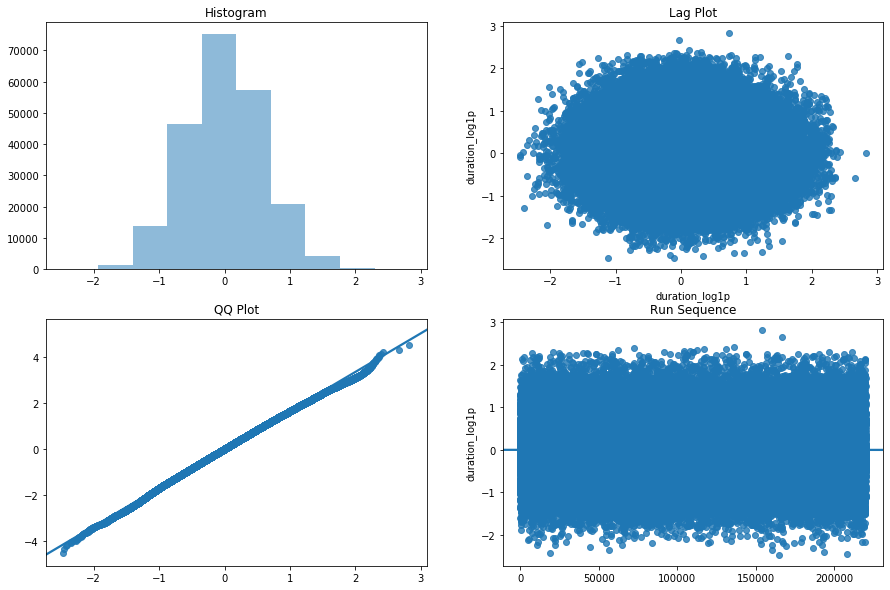

In [12]:
params_map = {
    'rf': {
        'rf__max_depth': [3],
        'rf__n_estimators': [300],
        'rf__min_samples_split': [2],
        'rf__min_samples_leaf': [1],
        'rf__min_weight_fraction_leaf': [0.0],
    },
    'gb': {
        'gb__max_depth': [5],
        'gb__n_estimators': [300],
        'gb__learning_rate': [0.1],
    },
    'ls': {
        'ls__alpha': [1.0, 0.5, 0.1],
        'ls__max_iter': [1000, 1500]
    },
    'rd': {
        'rd__alpha': [1.0],
        'rd__max_iter': [None]
    },
    'lg': {
        'lg__n_estimators': [150],
        'lg__num_leaves': [51],
        'lg__learning_rate': [0.1, 0.5]
    }
}

regressors = [
#     ('rf', RandomForestRegressor),
#     ('gb', GradientBoostingRegressor),
#     ('ls', Lasso),
#     ('rd', Ridge),
    ('lg', lgb.LGBMRegressor)
]

kf = KFold(n_splits=3, shuffle=True, random_state=33)

grid = run_randomsearch_with_pipe(
    regressors=regressors, 
    params_map=params_map,
    df_columns=use_columns,
    scorer=rmse_scorer,
    cv=kf,
    x1=x1,
    x2=x2,
    y1=y1,
    y2=y2
)

In [13]:
# LightGBM performs the best!

In [14]:
# Hypertuning lightgbm ...
# Work in progress ...